# C S 329E HW 12

# Association Analysis - Frequent Itemsets and Rule Generation

## Your name here (and your partner's name if you are working in a pair)

Association analysis extracts hidden relationships from large datasets. We'll be using one of the most commonly used algorithms for association rule mining: Apriori.

For this assignment you will be using the `MLxtend` library. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

You will need to install the `MLxtend` library. See the setup guide [here](http://rasbt.github.io/mlxtend/installation/).

## Bread Basket Data

The dataset belongs to "The Bread Basket" a bakery located in Edinburgh. The dataset has 21293 entires, over 6000 transactions and 4 columns:

  - **Date**: Categorical variable that tells us the date of the transactions (YYYY-MM-DD format).
  - **Time**: Categorical variable that tells us the time of the transactions (HH:MM:SS format). 
  - **Transaction**: Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction, that's why the data set has less transactions than observations.
  - **Item**: Categorical variable with the products.

You'll need to clean up the input data and convert it to a transaction list with itemsets, and find itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets you'll find association rules that have confidence above the `min_conf` threshold.

In [1]:
# Do not modify import block, all necessary imports are included

# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This is for our association analysis 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Q1 - Data Analysis
The data has been delivered to us in a format that doesn't match the transaction format that we used in the lecture to create frequent itemsets, but instead in a one item per line format that contains a transaction ID.  Let's visualize what kind of data we have.

Load the `BreadBasket.csv` file into a dataframe and:

  1. Plot the most frequent 20 items in a a histogram.  You may use panda's `value_counts` with the [matplotlib](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/categorical_variables.html) documentation on how to create a histogram with categorical data. Make sure your axis is readable and labeled.  I used a figsize of (15,5).
  2. Calculate how many unique items are in the dataset
  3. Calculate how many transactions there are in the dataset 
  
As you may notice there is an item with the name `NONE` ... remove all of those before you answer the above questions.

In [2]:
df_breadbasket = pd.read_csv('https://gist.githubusercontent.com/GregKuhlmann/1605ab44ac19c7edea5501d7a2dcc122/raw/1ad3ac582646a5389ea022e7d0e8e43686f3ffec/BreadBasket.csv')
df_breadbasket = df_breadbasket[df_breadbasket['Item'] != 'NONE']
df_breadbasket

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam
...,...,...,...,...
21288,2017-04-09,14:32:58,9682,Coffee
21289,2017-04-09,14:32:58,9682,Tea
21290,2017-04-09,14:57:06,9683,Coffee
21291,2017-04-09,14:57:06,9683,Pastry


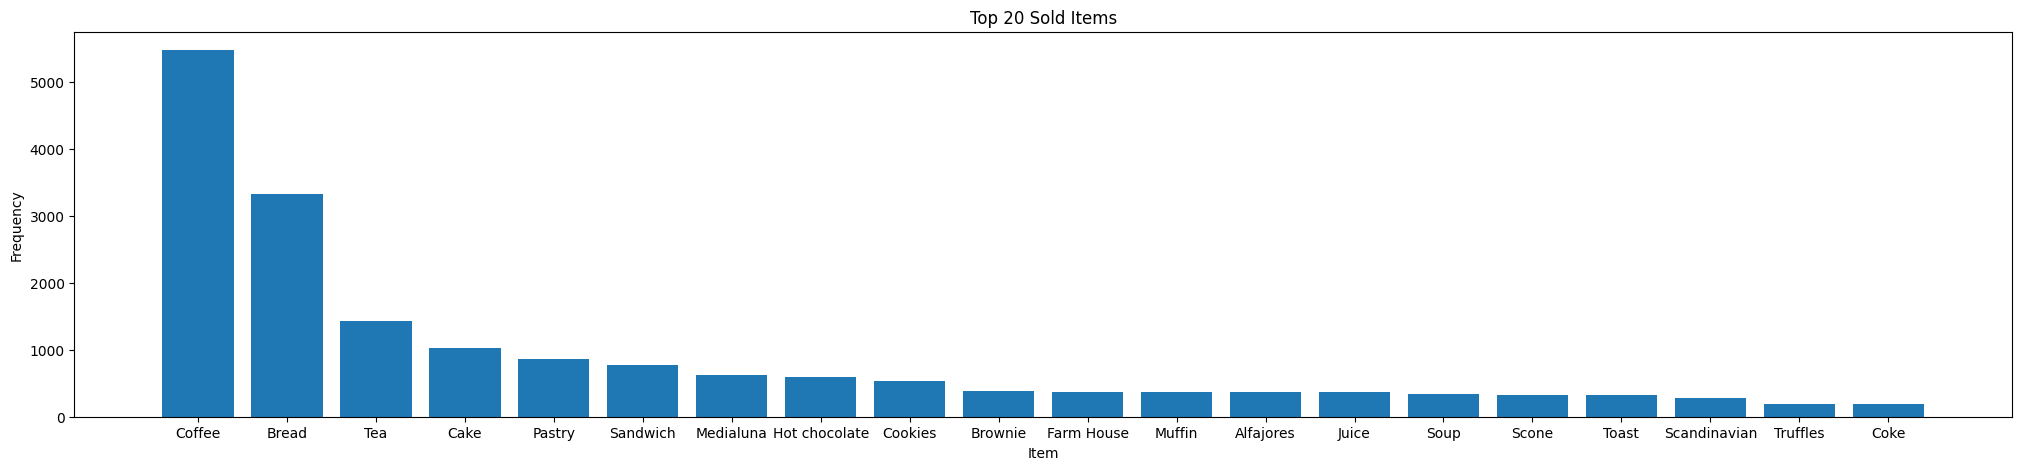

In [3]:
plt.figure(figsize=(25, 5))
top_twenty_items = df_breadbasket['Item'].value_counts().iloc[:20]
plt.title('Top 20 Sold Items')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.bar(top_twenty_items.index, top_twenty_items.values);

In [4]:
unique_items = len(df_breadbasket['Item'].value_counts())
print(f'Unique Item Count: {unique_items}')

Unique Item Count: 94


In [5]:
print(f"Transaction Count: {len(df_breadbasket['Transaction'].value_counts())}")


Transaction Count: 9465


## Q2 - Data Prep: Convert to One Hot Encoded Transactions
Convert the data to a transaction array.  The transaction array is a list of lists, for example:

```
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]
```

Pandas has a special function called `groupby` which we can use to collate all of the items with the same transaction ID into a list.  Here is a nice [tutorial](https://realpython.com/pandas-groupby/). You can get the list of lists of transactions by grouping the data by "Transaction" column, referencing the "Item" column, then applying a list.  This gives you a series with the transaction ID equal to the index, but the [TransactionEncoder](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/) to prep the data for our library just wants the values of that series. 

There are other methods you may use to create the transaction array using the `BreadBasked.csv` data with the `NONE` values filtered out, but they might require a little more code than the methodology suggested above.

Use the `mlxtend` TransactionEncoder library to encode the transaction array in a one hot encoding. Create the one hot encoding using the TransactionEncoder, and check it was done properly by looking at the first 4 transactions using the `inverse_transform`. Finish off the data prep for the frequent itemset generation by converting the transactions back to a dataframe using the [documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) as a reference. 

In [6]:
transaction_list = [list(value.values) for index, value in list(df_breadbasket.groupby('Transaction')['Item'])]

In [7]:
te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list)

In [8]:
te.inverse_transform(te_ary[:4])

[['Bread'], ['Scandinavian'], ['Cookies', 'Hot chocolate', 'Jam'], ['Muffin']]

In [9]:
df_breadbasket_onehot = pd.DataFrame(te_ary, columns=te.columns_)
df_breadbasket_onehot.head()

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Q3 - Create Frequent Itemsets 
Using the [apriori](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) method, create a frequent itemset that we can use to create rules with.  Unlike in the lecture notes, this implementation doesn't use an integer _minsup_ , it refers to support of the percent of the transactions that it has to contain to be frequent.  Since we have 9465 transactions, if we want _minsup_ to be 100, then the library expects a `min_support` fraction of $\frac{100}{9465}$. Find all the frequent item sets with _minsup_ set to 20. Show the last 15 frequent item sets displaying the item names (not the item column indices). 

In [10]:
apriori(df_breadbasket_onehot, min_support=20/9465)


,support,itemsets
0,0.004543,(1)
1,0.036344,(2)
2,0.004015,(4)
3,0.016059,(6)
4,0.005071,(7)
...,...,...
239,0.005388,"(73, 83, 23)"
240,0.002113,"(88, 73, 23)"
241,0.003381,"(83, 75, 23)"
242,0.002747,"(83, 78, 23)"


In [11]:
frequent_itemsets = apriori(df_breadbasket_onehot, min_support=20/9465, use_colnames=True)
frequent_itemsets.iloc[-15:]


,support,itemsets
229,0.003909,"(Coffee, Tea, Cookies)"
230,0.003064,"(Coffee, Hot chocolate, Medialuna)"
231,0.003803,"(Coffee, Pastry, Hot chocolate)"
232,0.002536,"(Sandwich, Hot chocolate, Coffee)"
233,0.002747,"(Sandwich, Coffee, Juice)"
234,0.004860,"(Pastry, Coffee, Medialuna)"
235,0.003698,"(Coffee, Tea, Medialuna)"
236,0.002853,"(Coffee, Tea, Muffin)"
237,0.004649,"(Coffee, Pastry, Tea)"
238,0.003592,"(Sandwich, Soup, Coffee)"


## Q4 - Generate Strong Rules
Use the [association_rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) to calculate rules with a confidence level of 0.5 for the frequent itemsets you generated in Q3.

You should notice something in common with all of the rules.  Are these rules helpful for our bakery? 

In [12]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
1,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752,0.302021
2,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741,0.209236
3,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
4,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700
5,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575,0.415249
6,(Frittata),(Coffee),0.008558,0.478394,0.004543,0.530864,1.109680,0.000449,1.111844,0.099692
7,(Hearty & Seasonal),(Coffee),0.010565,0.478394,0.005705,0.540000,1.128777,0.000651,1.133926,0.115303
8,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553,0.060403
9,(Jammie Dodgers),(Coffee),0.013207,0.478394,0.006656,0.504000,1.053525,0.000338,1.051625,0.051485


## Yes it tells the bakery that if a customer buys a set of items they are more likely to buy a coffee than any other item along with it.

## Q5 - Generate Strong Rules (pt 2)
While reading the documentation for creating [association rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) you notice that there are many other metrics to choose from.  Try creating rules with the following:
   - lift > 3
   - leverage > 0.004
   - conviction > 1.2

In [13]:
association_rules(frequent_itemsets, metric="lift", min_threshold=3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Sandwich),(Coke),0.071844,0.019440,0.005177,0.072059,3.706722,0.003780,1.056705,0.786742
1,(Coke),(Sandwich),0.019440,0.071844,0.005177,0.266304,3.706722,0.003780,1.265043,0.744697
2,(Fudge),(Jam),0.015003,0.015003,0.002536,0.169014,11.265622,0.002311,1.185336,0.925114
3,(Jam),(Fudge),0.015003,0.015003,0.002536,0.169014,11.265622,0.002311,1.185336,0.925114
4,(Jammie Dodgers),(Juice),0.013207,0.038563,0.002113,0.160000,4.149041,0.001604,1.144568,0.769138
5,(Juice),(Jammie Dodgers),0.038563,0.013207,0.002113,0.054795,4.149041,0.001604,1.043999,0.789423
6,(Juice),(Spanish Brunch),0.038563,0.018172,0.002747,0.071233,3.919879,0.002046,1.057130,0.774768
7,(Spanish Brunch),(Juice),0.018172,0.038563,0.002747,0.151163,3.919879,0.002046,1.132652,0.758677
8,(Sandwich),(Mineral water),0.071844,0.014157,0.003275,0.045588,3.220094,0.002258,1.032932,0.742817
9,(Mineral water),(Sandwich),0.014157,0.071844,0.003275,0.231343,3.220094,0.002258,1.207504,0.699351


In [14]:
association_rules(frequent_itemsets, metric="leverage", min_threshold=0.004)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Coffee),(Cake),0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905,0.176684
1,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
2,(Hot chocolate),(Cake),0.058320,0.103856,0.011410,0.195652,1.883874,0.005354,1.114125,0.498236
3,(Cake),(Hot chocolate),0.103856,0.058320,0.011410,0.109868,1.883874,0.005354,1.057910,0.523553
4,(Tea),(Cake),0.142631,0.103856,0.023772,0.166667,1.604781,0.008959,1.075372,0.439556
5,(Cake),(Tea),0.103856,0.142631,0.023772,0.228891,1.604781,0.008959,1.111865,0.420538
6,(Coffee),(Medialuna),0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667,0.305936
7,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
8,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
9,(Coffee),(Pastry),0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740,0.256084


In [15]:
association_rules(frequent_itemsets, metric="conviction", min_threshold=1.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752,0.302021
1,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741,0.209236
2,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575,0.415249
3,(Keeping It Local),(Coffee),0.006656,0.478394,0.005388,0.809524,1.692169,0.002204,2.738431,0.411783
4,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
5,(Salad),(Coffee),0.010460,0.478394,0.006550,0.626263,1.309094,0.001547,1.395648,0.238608
6,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235,0.204851
7,(Tartine),(Coffee),0.004860,0.478394,0.003064,0.630435,1.317815,0.000739,1.411404,0.242346
8,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
9,(Vegan mincepie),(Coffee),0.005494,0.478394,0.003170,0.576923,1.205958,0.000541,1.232887,0.171727


## Q6 - Create Actionable Business Insight
Pretend you are a consultant contracted to work for this bakery and come up with a promotion to increase sales. You have performed the above analysis, now how would you suggest the bakery use this data?

Be creative.  It could be in training employees, programming the cash register, advertising specials, etc.. Describe your approach and why you think the data supports it.  

#### 1) Looking at the association rule when conviction > 1.2, we see that often times as a result of a dessert being bought(i.e. cake,        brownie, etc.) the customer has a tendency to buy a coffee on the side as well. Therefore I would recommend offering a 99¢ alongside any dessert bought at the bakery. While we would take an intial loss on the decreased margins, the hope is that we would be able to increase our volume sold as people who buy desserts would be more likely than ever to buy a coffee, due to its cheap price.

#### 2) Again using the rule where conviction > 1.2, we tend to see that customers who buy a drink also end up buying a sandwich, therefore I propose that we create a combo meal with a sandwich and drink included for a price that is more than the value of the sandwich alone but a little less than the price of the two individual items. For many of the same reasons above, this would increase profits by incentivizing more spending, in a better deal for customers

#### 3) Using the rule when leverage > 0.004, we see that cake tends to be bough alongside a hot, caffineted beverage. Therefore I recommend that those drinks(coffee or tea) be placed right next to the cake section of the menu, so that customers eyes will associate buying cake and a hot beverage together when ordering at the counter. 

#### 4) I also recomend placing an emphasis on advertising items that are more main staples than sides or drinks. For example, most people will not walk into the bakery seeking juice, mineral water, Jammy Dodger,etc. these are just purchases made while ordering their main item such as soup, sandwiches, coffee, etc. Thus I think an increase in focus on advertising these main items will increase sales across the board.